# Imperfect conductor - Discussion

In [1]:
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/imperfect_conductor')

%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
cm = matplotlib.cm.get_cmap('viridis')

import fenics as fen
from imperfect_conductor import ImperfectConductor

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

## Imperfect conductor

In [3]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 101, 21
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
imp = fen.Expression('1.0', degree=2)
RC = ImperfectConductor(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N, imp=imp)
RC.setup()
#RC.plot_g_N()

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

### Full cavity

/home/fenics/shared/src/time_harmonic_maxwell_problem.py:356: ComplexWarning: Casting complex values to real discards the imaginary part
  u_vec_inserted[inner_indices] = u_vec


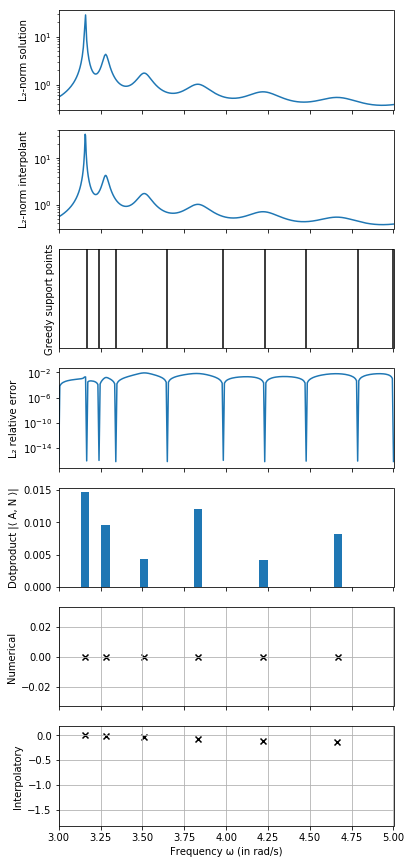

In [30]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.complex_scatter(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.complex_scatter(ax[6], MRI.get_interpolatory_eigenfrequencies())

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

/home/fenics/shared/examples/imperfect_conductor/imperfect_conductor.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  u_func.vector()[:] = u_vec


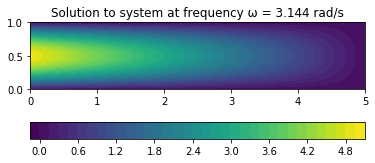

In [21]:
omega = eigfreqs[0]
RC.solve(omega)
sol = RC.get_solution()[0]
RC.plot_external_solution(sol, contains_boundary_values=True, omega=omega)

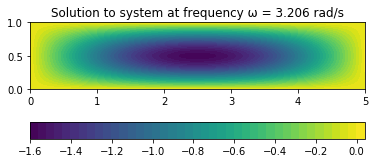

In [22]:
omega = eigfreqs[1]
RC.solve(omega)
sol = RC.get_solution()[0]
RC.plot_external_solution(sol, contains_boundary_values=True, omega=omega)

### Higher impedance

In [23]:
RC.imp = fen.Expression('10.0', degree=2)
RC.setup()

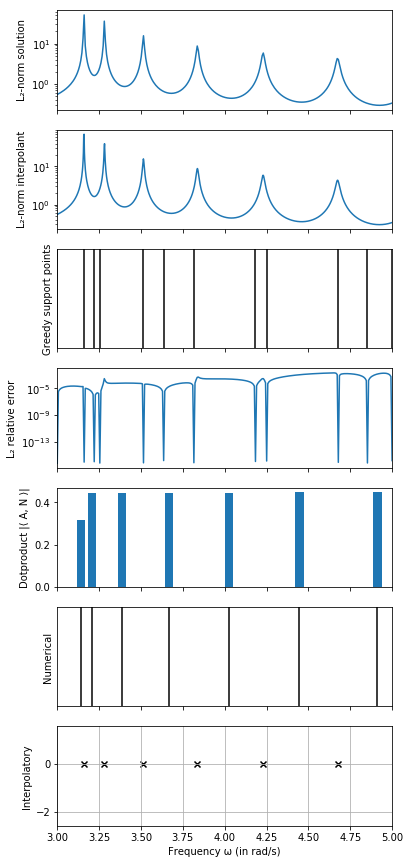

In [24]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.plot_lines(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.complex_scatter(ax[6], MRI.get_interpolatory_eigenfrequencies())

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()